# Sentiment analysis with NLTK Naive Bayes

## Naive Bayes with NLTK

***A Naive Bayes classifier determines the probability that an input text belongs to one of a set of classes, eg. predicting if a review is positive or negative.***

***Naive Bayes is one of the most straightforward and fast classification algorithms [1] and has been successfully used in a variety of NLP tasks, notably spam filtering and text classification. It is a supervised learning algorithm that uses the Bayes theorem of probability for the prediction of unknown classes [2]. It’s “naive” because it assumes conditional independence between every pair of features (words, in our case).***

***In natural human language, the set, frequency, and especially order of words convey contextual information (e.g. the difference in meaning between “good” and “not good”). Despite these assumptions of conditional independence, Naive Bayes can often have a high degree of accuracy. In our case, the positive or negative affect of a movie review in English tends to rely on the semantic content of a few key words (amazing, garbage, awful,underrated, etc.) over contextual word order, making this a suitable task for the Naive Bayes model.***

References
- [1] Zhang, H. (2004). The optimality of naive Bayes. Aa, 1(2), 3. https://www.aaai.org/Papers/FLAIRS/2004/Flairs04-097.pdf
- [2] https://www.nltk.org/_modules/nltk/classify/naivebayes.html

### imports

In [20]:
import nltk
from nltk.metrics.scores import precision, recall, f_measure
import pandas as pd
import collections
import plotly.express as px
from IPython.display import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from NLPmoviereviews.data import load_data_sent
from NLPmoviereviews.utilities import preprocessing

In [21]:
import plotly.io as pio
pio.renderers.default = 'notebook'

### 1. Load data

In [22]:
# load data
X_train, y_train, X_test, y_test = load_data_sent(percentage_of_sentences=100);

### 2. Prepare text

In [5]:
# remove custom stop-words
def rm_custom_stops(sentence):
    '''
    Custom stop word remover
    Parameters:
        sentence (str): a string of words
    Returns:
        list_of_words (list): cleaned sentence as a list of words
    '''
    words = sentence.split()
    stop_words = {'movie', 'film', 'br', 'x96'}
    
    return [w for w in words if not w in stop_words]

In [6]:
# perform preprocessing (cleaning) & transform to dataframe
def process_df(X, y):
    '''
    Transform texts and labels into dataframe of 
    cleaned texts (as list of words) and human readable target labels
    
    Parameters:
        X (list): list of strings (reviews)
        y (list): list of target labels (0/1)
    Returns:
        df (dataframe): dataframe of processed reviews (as list of words)
                        and corresponding sentiment label (positive/negative)
    '''
    # create dataframe from data
    d = {'text': X, 'sentiment': y}
    df = pd.DataFrame(d)
    
    # make sentiment human-readable
    df['sentiment'] = df.sentiment.map(lambda x: 'positive' if x==1 else 'negative')

    # clean and split text into list of words
    df['text'] = df.text.apply(preprocessing)
    df['text'] = df.text.apply(rm_custom_stops)

    return df

In [7]:
# process data
train_df = process_df(X_train, y_train)
test_df = process_df(X_test, y_test)

In [8]:
# inspect dataframe
train_df.head()

,text,sentiment
0,"[absolutely, terrible, dont, lure, christopher...",negative
1,"[know, fall, asleep, usually, due, combination...",negative
2,"[mann, photograph, alberta, rocky, mountain, s...",negative
3,"[kind, snowy, sunday, afternoon, rest, world, ...",positive
4,"[others, mention, woman, go, nude, mostly, abs...",positive


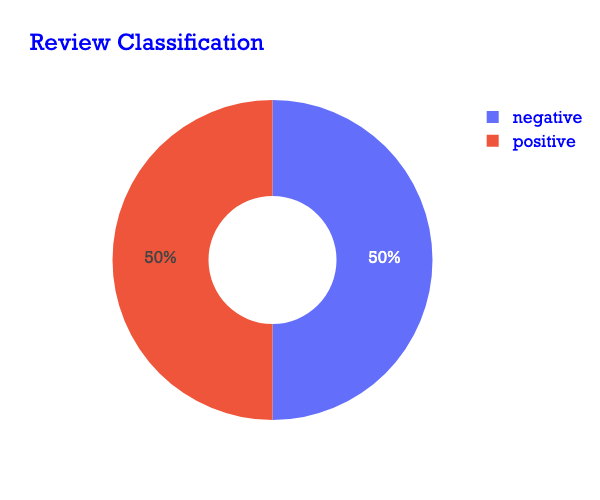

In [25]:
# plot class distribution
df = train_df
df['dummy'] = 1
fig = px.pie(df, values='dummy', names='sentiment', hole=0.4,
             title='Review Classification', width=600)
fig.update_layout(font_family="Rockwell", font_color="blue", font_size=16);

# static plot
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### 3. Create list of most common words

In [10]:
# get frequency distribution of words in corpus & select 2000 most common words
def most_common(df, n=2000):
    '''
    Get n most common words from data frame of text reviews
    
    Parameters:
        df (dataframe): dataframe with column of processed text reviews
        n (int): number of most common words to get
    Returns:
        most_common_words (list): list of n most common words
    '''
    # create list of all words in the train data
    complete_corpus = df.text.sum()
    
    # Construct a frequency dict of all words in the overall corpus 
    all_words = nltk.FreqDist(w.lower() for w in complete_corpus)

    # select the 2,000 most frequent words (incl. frequency)
    most_common_words = all_words.most_common(n)
    
    return [item[0] for item in most_common_words], most_common_words

In [11]:
# get 2000 most common words/word-frequencies
most_common_2000, word_frequencies_2000 = most_common(train_df)

# inspect first 10 most common words
most_common_2000[0:10]

['one',
 'make',
 'like',
 'see',
 'get',
 'time',
 'good',
 'character',
 'go',
 'watch']

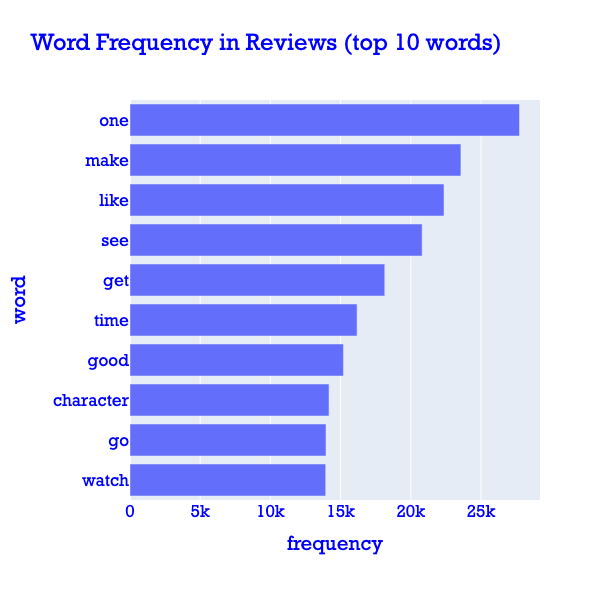

In [24]:
# plot word frequencies
df = pd.DataFrame(word_frequencies_2000)
df.columns = ['word', 'frequency']

# create bar chart
fig = px.bar(df[0:10], y='word', x='frequency', 
             title="Word Frequency in Reviews (top 10 words)", 
             width=600, height=600)
fig.update_layout(font_family="Rockwell", font_color="blue", font_size=16,
                  margin=dict(l=130, r=60, t=100, b=100));
fig.update_xaxes(tickfont=dict(family='Rockwell', size=16))
fig.update_yaxes(tickfont=dict(family='Rockwell', size=16), autorange="reversed");

# static plot
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### 4. Create nltk featuresets from train/test

***For the nltk naive bayes classifier, we must tokenize the sentence and figure out which words the sentence shares with all_words/most_common_words. These constitute the sentence's features.***

In [13]:
# for a given text, create a featureset (dict of features - {'word': True/False})
def review_features(review, most_common_words):
    '''
    Feature extractor that checks whether each of the most
    common words is present in a given review
    
    Parameters:
        review (list): text reviews as list of words
        most_common_words (list): list of n most common words
    Returns:
        features (dict): dict of most common words & corresponding True/False
    '''
    review_words = set(review)
    features = {}
    for word in most_common_words:
        features['contains(%s)' % word] = (word in review_words)
    return features

In [14]:
# create featureset for each text in a given dataframe

def make_set(df, most_common_words):
    '''
    Generates nltk featuresets for each movie review in dataframe.
    Feature sets are composed of a dict describing whether each of the most 
    common words is present in the text review or not

    Parameters:
        df (dataframe): processed dataframe of text reviews
        most_common_words (list): list of most common words
    Returns:
        feature_set (list): list of dicts of most common words & corresponding True/False
    '''
    return [(review_features(df.text[i], most_common_words), df.sentiment[i]) for i in range(len(df.sentiment))]

In [15]:
# make data into featuresets (for nltk naive bayes classifier)

train_set = make_set(train_df, most_common_2000)
test_set = make_set(test_df, most_common_2000)

In [16]:
# inspect first train featureset

first_label = train_set[0][1]
first_featureset_first10 = list(train_set[0][0].items())[:10]
first_featureset_first10, first_label

([('contains(one)', False),
  ('contains(make)', True),
  ('contains(like)', True),
  ('contains(see)', False),
  ('contains(get)', False),
  ('contains(time)', False),
  ('contains(good)', True),
  ('contains(character)', False),
  ('contains(go)', False),
  ('contains(watch)', False)],
 'negative')

### 5. Train & evaluate model (naive bayes classifier)



In [17]:
# Train a naive bayes classifier with train set by nltk
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [18]:
# Get the accuracy of the naive bayes classifier with test set
accuracy = nltk.classify.accuracy(classifier, test_set)
accuracy

0.84044

In [19]:
# build reference and test set of observed values (for each label)
refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)
 
for i, (feats, label) in enumerate(train_set):
    refsets[label].add(i)
    observed = classifier.classify(feats)
    testsets[observed].add(i)


In [20]:
# print precision, recall, and f-measure
print('pos precision:', precision(refsets['positive'], testsets['positive']))
print('pos recall:', recall(refsets['positive'], testsets['positive']))
print('pos F-measure:', f_measure(refsets['positive'], testsets['positive']))
print('neg precision:', precision(refsets['negative'], testsets['negative']))
print('neg recall:', recall(refsets['negative'], testsets['negative']))
print('neg F-measure:', f_measure(refsets['negative'], testsets['negative']))

pos precision: 0.8434679334916865
pos recall: 0.85224
pos F-measure: 0.8478312773577398
neg precision: 0.8506871463217461
neg recall: 0.84184
neg F-measure: 0.8462404503417773


In [21]:
# show top n most informative features
classifier.show_most_informative_features(20)

Most Informative Features
       contains(unfunny) = True           negati : positi =     14.1 : 1.0
     contains(pointless) = True           negati : positi =     10.4 : 1.0
     contains(laughable) = True           negati : positi =      9.1 : 1.0
         contains(worst) = True           negati : positi =      9.0 : 1.0
         contains(lousy) = True           negati : positi =      8.9 : 1.0
         contains(waste) = True           negati : positi =      8.9 : 1.0
         contains(awful) = True           negati : positi =      8.5 : 1.0
        contains(poorly) = True           negati : positi =      8.2 : 1.0
   contains(wonderfully) = True           positi : negati =      7.6 : 1.0
          contains(lame) = True           negati : positi =      6.9 : 1.0
      contains(pathetic) = True           negati : positi =      6.4 : 1.0
    contains(delightful) = True           positi : negati =      6.0 : 1.0
   contains(beautifully) = True           positi : negati =      5.8 : 1.0

***We can see that people who give a positive review of a film are more likely to use words such as "wonderfully", "delightful", "underrate", or "superb", while people who give a negative review are more likely to use words such as "unfunny", "pointless", "lame", or "garbage". Moreover, words from negative reviews seem to be informing the model more than words from positive reviews.***

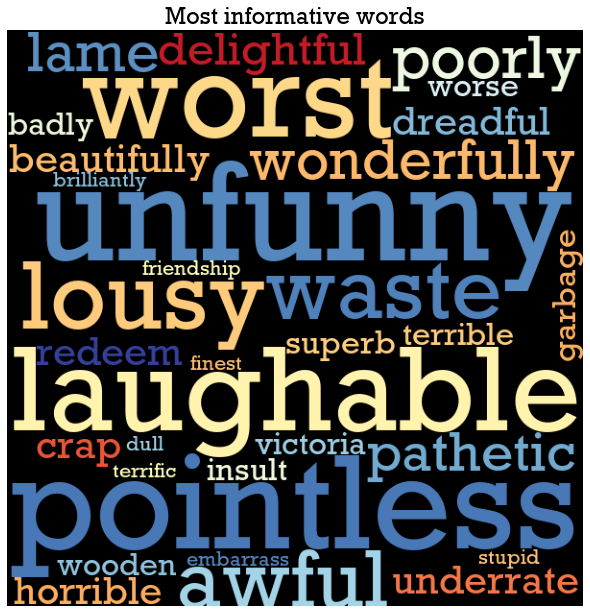

In [368]:
# get most informative words
most_informative = []
for (word, fval) in classifier.most_informative_features(50):
    most_informative.append(word[9:-1])
informative_sentence = ' '.join(most_informative)

# create WordCloud
wordcloud = WordCloud(width = 600, height = 600,
                      font_path = '/System/Library/Fonts/Supplemental/Rockwell.ttc',
                    #   background_color ='white',
                      colormap='RdYlBu',
                      min_font_size = 20).generate(informative_sentence)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Most informative words', fontfamily='Rockwell',fontsize=22)
plt.show()

### 6. Make prediction

In [22]:
# predict on new review (from mubi.com)
new_review = "Surprisingly effective and moving, The Balcony Movie takes the Front Up\
            concept of talking to strangers, but here attaches it to a fixed perspective \
            in order to create a strong sense of the stream of life passing us by. \
            It's possible to not only witness the subtle changing of seasons\
            but also the gradual opening of trust and confidence in Lozinski's \
            repeating characters. A Pandemic movie, pre-pandemic. 3.5 stars"

In [23]:
# perform preprocessing (cleaning & featureset transformation)
processed_review = rm_custom_stops(preprocessing(new_review))
processed_review = review_features(processed_review, most_common_2000)

In [24]:
# predict label
classifier.classify(processed_review)

'positive'

In [25]:
# to get individual probability for each label and word, taken from:
# https://stackoverflow.com/questions/20773200/python-nltk-naive-bayes-probabilities

# show individual probabilities for top 10 most informative words
for label in classifier.labels():
    indv_probs = []
    for (word, fval) in classifier.most_informative_features(10):
        _prob = "{0:.2f}%".format(100*classifier._feature_probdist[label, word].prob(fval))
        indv_probs.append(f"{word}: {_prob}")
    print(pd.DataFrame({label: indv_probs}))

                       negative
0      contains(unfunny): 1.75%
1    contains(pointless): 3.36%
2    contains(laughable): 2.88%
3       contains(worst): 16.34%
4        contains(lousy): 1.46%
5       contains(waste): 13.71%
6       contains(awful): 10.34%
7       contains(poorly): 4.49%
8  contains(wonderfully): 0.29%
9         contains(lame): 4.52%
                       positive
0      contains(unfunny): 0.12%
1    contains(pointless): 0.32%
2    contains(laughable): 0.32%
3        contains(worst): 1.82%
4        contains(lousy): 0.16%
5        contains(waste): 1.54%
6        contains(awful): 1.22%
7       contains(poorly): 0.55%
8  contains(wonderfully): 2.21%
9         contains(lame): 0.65%
